In [9]:

import os, shutil
from glob import glob
import numpy as np
import pandas as pd
from natsort import natsorted
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')


In [10]:
in_dir = "out01_tms_induced_respose/"
in_dir2 = "data_subject_info/"

out_dir = "out02_two_sample_ttest_gender_and_boxplot/"
in_file_name = "HRF_tms_induced_response.csv"

if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
complete_df = pd.read_csv(in_dir + in_file_name)

subject_info = pd.read_csv(in_dir2 + "age_gender_edu.txt", sep = ',')
data = subject_info.merge(complete_df, left_on = 'cc_post_intake_id', right_on = 'subject')
data.drop(labels = ['inputfile', 'cc_post_intake_id'], axis = 1, inplace = True)
data.replace({'gender': {1: "male", 2: "female"}}, inplace = True)
data

,gender,age,yrs_of_edu,subject,site,group,tms_site_response_standard,tms_site_response_individual_6mm,tms_site_response_individual_10mm,tms_site_response_individual_14mm,tms_site_response_individual_14-10mm,tms_site_response_individual_10-6mm
0,female,45,18,1001,L_Fp,NTHC,0.287125,0.439684,0.456288,0.395807,0.354767,0.462649
1,female,45,18,1001,L_pMFG,NTHC,-0.358279,-0.463813,-0.439631,-0.329946,-0.264645,-0.431570
2,female,45,18,1001,R_FEF,NTHC,-0.252532,-0.423779,-0.511036,-0.496599,-0.487678,-0.540984
3,female,45,18,1001,R_Fp,NTHC,0.245202,0.278052,0.265166,0.243850,0.230372,0.260594
4,female,45,18,1001,R_M1,NTHC,-1.002989,-1.403756,-1.606550,-1.550770,-1.520768,-1.663231
...,...,...,...,...,...,...,...,...,...,...,...,...
787,male,22,14,2108,R_IPL,TEHC,1.236482,0.391417,1.001566,1.383794,1.611196,1.196951
788,male,22,14,2108,R_M1,TEHC,0.124382,0.233850,0.166974,0.150504,0.140419,0.144036
789,male,22,14,2108,R_aMFG,TEHC,-0.279814,-0.045608,-0.032161,-0.082834,-0.115168,-0.027050
790,male,22,14,2108,R_pMFG,TEHC,0.363362,-0.020677,0.119496,0.184963,0.224639,0.165267


In [12]:
## run 1 sample t-test for each roi:
pd.options.mode.chained_assignment = None # avoid the warnning message for assigning values to slices of df.
from scipy.stats import ttest_ind

def format_table(report):
    report2 = report.copy()
    report2[report.gt(0)] = report2[report.gt(0)].astype(str).apply(lambda x : x.str[:5])
    report2[report.lt(0)] = report2[report.lt(0)].astype(str).apply(lambda x : x.str[:6])
    
    report_pvalue = report2.iloc[1::3,:]
    report_pvalue[report.iloc[1::3,:].le(0.05)] = \
    report_pvalue[report.iloc[1::3,:].le(0.05)].apply(lambda x : x.str[:5]).add('*')

    report_pvalue = report2.iloc[1::3,:]
    report_pvalue[report.iloc[1::3,:].le(0.01)] = \
    report_pvalue[report.iloc[1::3,:].le(0.01)].apply(lambda x : x.str[:5]).add('**')
        
    return report2

test_variables = ['tms_site_response_standard', 'tms_site_response_individual_6mm',
                  'tms_site_response_individual_10mm', 'tms_site_response_individual_14mm', 
                  'tms_site_response_individual_14-10mm', 'tms_site_response_individual_10-6mm']
plot_x_order = ["L_Fp","R_Fp","L_aMFG","R_aMFG","L_pMFG","R_pMFG","R_IFJ","R_FEF","R_M1","R_preSMA","R_IPL"]

row_index = pd.MultiIndex.from_tuples([(i , j) for i in test_variables for j in ['t value', 'p value', "Cohen's d"]])
result = pd.DataFrame(index = row_index, columns = plot_x_order)

# statistical tests for each roi and roi setting:
for var in test_variables:
    for tms in plot_x_order:
        male = data.loc[(data['site']==tms) & (data['gender']=='male') & (~data[var].isna()), var]
        female = data.loc[(data['site']==tms) & (data['gender']=='female') & (~data[var].isna()), var]
        t, p = ttest_ind(male, female)
        
        cohend = (np.mean(male) - np.mean(female)) / (np.sqrt((np.std(male) ** 2 + np.std(female) ** 2) / 2))
        
        result.loc[(var, 't value'), tms] = t
        result.loc[(var, 'p value'), tms] = p
        result.loc[(var, "Cohen's d"), tms] = cohend

result = format_table(result)
# save results separately for each roi setting:
for var in test_variables:
    result.loc[(var, ['t value', 'p value', "Cohen's d"]), :].to_csv(out_dir + 'response_' + var + '.csv')

result.to_csv(out_dir + 'response_all.csv')
result.loc[(test_variables, ['p value', "Cohen's d"]),:]

L_Fp    R_Fp   L_aMFG  \
tms_site_response_standard           p value     0.328   0.271   0.012*   
                                     Cohen's d   0.255  -0.278    0.626   
tms_site_response_individual_6mm     p value     0.710   0.709    0.071   
                                     Cohen's d  -0.104  -0.114    0.460   
tms_site_response_individual_10mm    p value     0.401   0.575   0.027*   
                                     Cohen's d  -0.234  -0.166    0.572   
tms_site_response_individual_14mm    p value     0.458   0.563   0.011*   
                                     Cohen's d  -0.207  -0.171    0.664   
tms_site_response_individual_14-10mm p value     0.470   0.587  0.008**   
                                     Cohen's d  -0.202  -0.160    0.691   
tms_site_response_individual_10-6mm  p value     0.343   0.564   0.021*   
                                     Cohen's d  -0.264  -0.171    0.597   

                                                R_aMFG  L_pMFG R_pMFG   R_IFJ  \
tms_site_response_standard           p value     0.544   0.949  0.113   0.843   
                                     Cohen's d  -0.135  -0.014  0.368  -0.046   
tms_site_response_individual_6mm     p value     0.616   0.621  0.516   0.502   
                                     Cohen's d  -0.118   0.124  0.162   0.170   
tms_site_response_individual_10mm    p value     0.459   0.897  0.380   0.621   
                                     Cohen's d  -0.175   0.032  0.216   0.125   
tms_site_response_individual_14mm    p value     0.308   0.887  0.288   0.687   
                                     Cohen's d  -0.243  -0.035  0.260   0.103   
tms_site_response_individual_14-10mm p value     0.247   0.740  0.250   0.743   
                                     Cohen's d  -0.278  -0.082  0.281   0.084   
tms_site_response_individual_10-6mm  p value     0.407   0.971  0.335   0.668   
                                     Cohen's d  -0.197   0.008  0.238   0.109   

                                                R_FEF    R_M1 R_preSMA   R_IPL  
tms_site_response_standard           p value    0.581   0.994    0.534   0.298  
                                     Cohen's d  0.127   0.001    0.155   0.311  
tms_site_response_individual_6mm     p value    0.459   0.646    0.080   0.633  
                                     Cohen's d  0.180  -0.112    0.477  -0.149  
tms_site_response_individual_10mm    p value    0.580   0.975    0.081   0.769  
                                     Cohen's d  0.136  -0.007    0.471   0.091  
tms_site_response_individual_14mm    p value    0.683   0.802    0.088   0.282  
                                     Cohen's d  0.102   0.060    0.458   0.343  
tms_site_response_individual_14-10mm p value    0.719   0.688    0.097   0.125  
                                     Cohen's d  0.091   0.096    0.445   0.496  
tms_site_response_individual_10-6mm  p value    0.597   0.912    0.083   0.574  
                                     Cohen's d  0.130   0.026    0.468   0.177

In [4]:
## boxplot of response (gender by site):

a4_dims = (12, 8)
tms_sites = complete_df['site'].unique()
plot_x_order = ["L_Fp","R_Fp","L_aMFG","R_aMFG","L_pMFG","R_pMFG","R_IFJ","R_FEF","R_M1","R_preSMA","R_IPL"]

colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(tms_sites)).as_hex()
colors = colors[1::2] + colors[2::2] 

def plot_response(ylabel, pvalue, cohend):

    fig, ax = plt.subplots(figsize=a4_dims, dpi=300)
    sns.swarmplot(y = ylabel, x = "site", data = data,
                  hue = 'gender', 
                  order=plot_x_order,
                  dodge=True, ax = ax, facecolors='none',
                  palette = colors, #plot_kws={'scatter_kws': {'alpha': 0.1}}
                  alpha = .75, size=4)

    sns.boxplot(y = ylabel, x = "site", data = data,
                hue = 'gender', 
                order=plot_x_order,
                palette = colors, notch = True, ax = ax)
    
    for i,artist in enumerate(ax.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # sns.boxplot(data=df,x="site",y="tms_site_response",dodge=True,showfliers=False,
                # showbox=True,linewidth=0.8,color = "w");
        
    # add annotations:
    locs, _ = plt.xticks()
    y = 3
    for i, x in enumerate(locs):
        ax.text(x-.3, y, "${p}$=" + pvalue[i], ha='left', va='bottom', color='k', size = 10)
        ax.text(x-.3, y+.25, "${d}$=" + cohend[i], ha='left', va='bottom', color='k', size = 10)
        
    
#     for legpatch in ax.get_legend().get_patches():
#         col = legpatch.get_facecolor()
#         legpatch.set_edgecolor('None')
#         legpatch.set_facecolor('None')
        
    handles, labels = ax.get_legend_handles_labels()
    # When creating the legend, only use the first two elements
    # to effectively remove the first/last n.
    l = ax.legend(handles[2:], labels[2:], borderaxespad=0., loc = 'lower right', columnspacing = 1.2,
                   frameon = False, markerscale =1.1, handlelength = .1,
                   prop = {'size': 10}, title = '', bbox_to_anchor=(.99, .15), ncol=2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_xlim([-1, len(tms_sites)])
    ax.set_ylabel("Mean TMS Site Response")
    ax.set_xlabel("TMS Site");

    # Add horizontal red lines indicating mean of violinplot
#     spread = 0.1
#     for i, label in enumerate(ax.get_xticklabels()):
#         tms = label.get_text()
#         mean = np.nanmean(complete_df[complete_df['site']==str(tms)]['tms_site_response_standard'])
#         ax.hlines(mean, i-spread, i+spread, colors='red')
    ax.hlines(0, -1, len(tms_sites), linestyles='dotted', colors='grey')
    
    return fig

In [5]:
# fig = plot_response("tms_site_response_standard", result.loc[(var, 'p value'),:], result.loc[(var, "Cohen's d"),:])

tms_site_response_standard


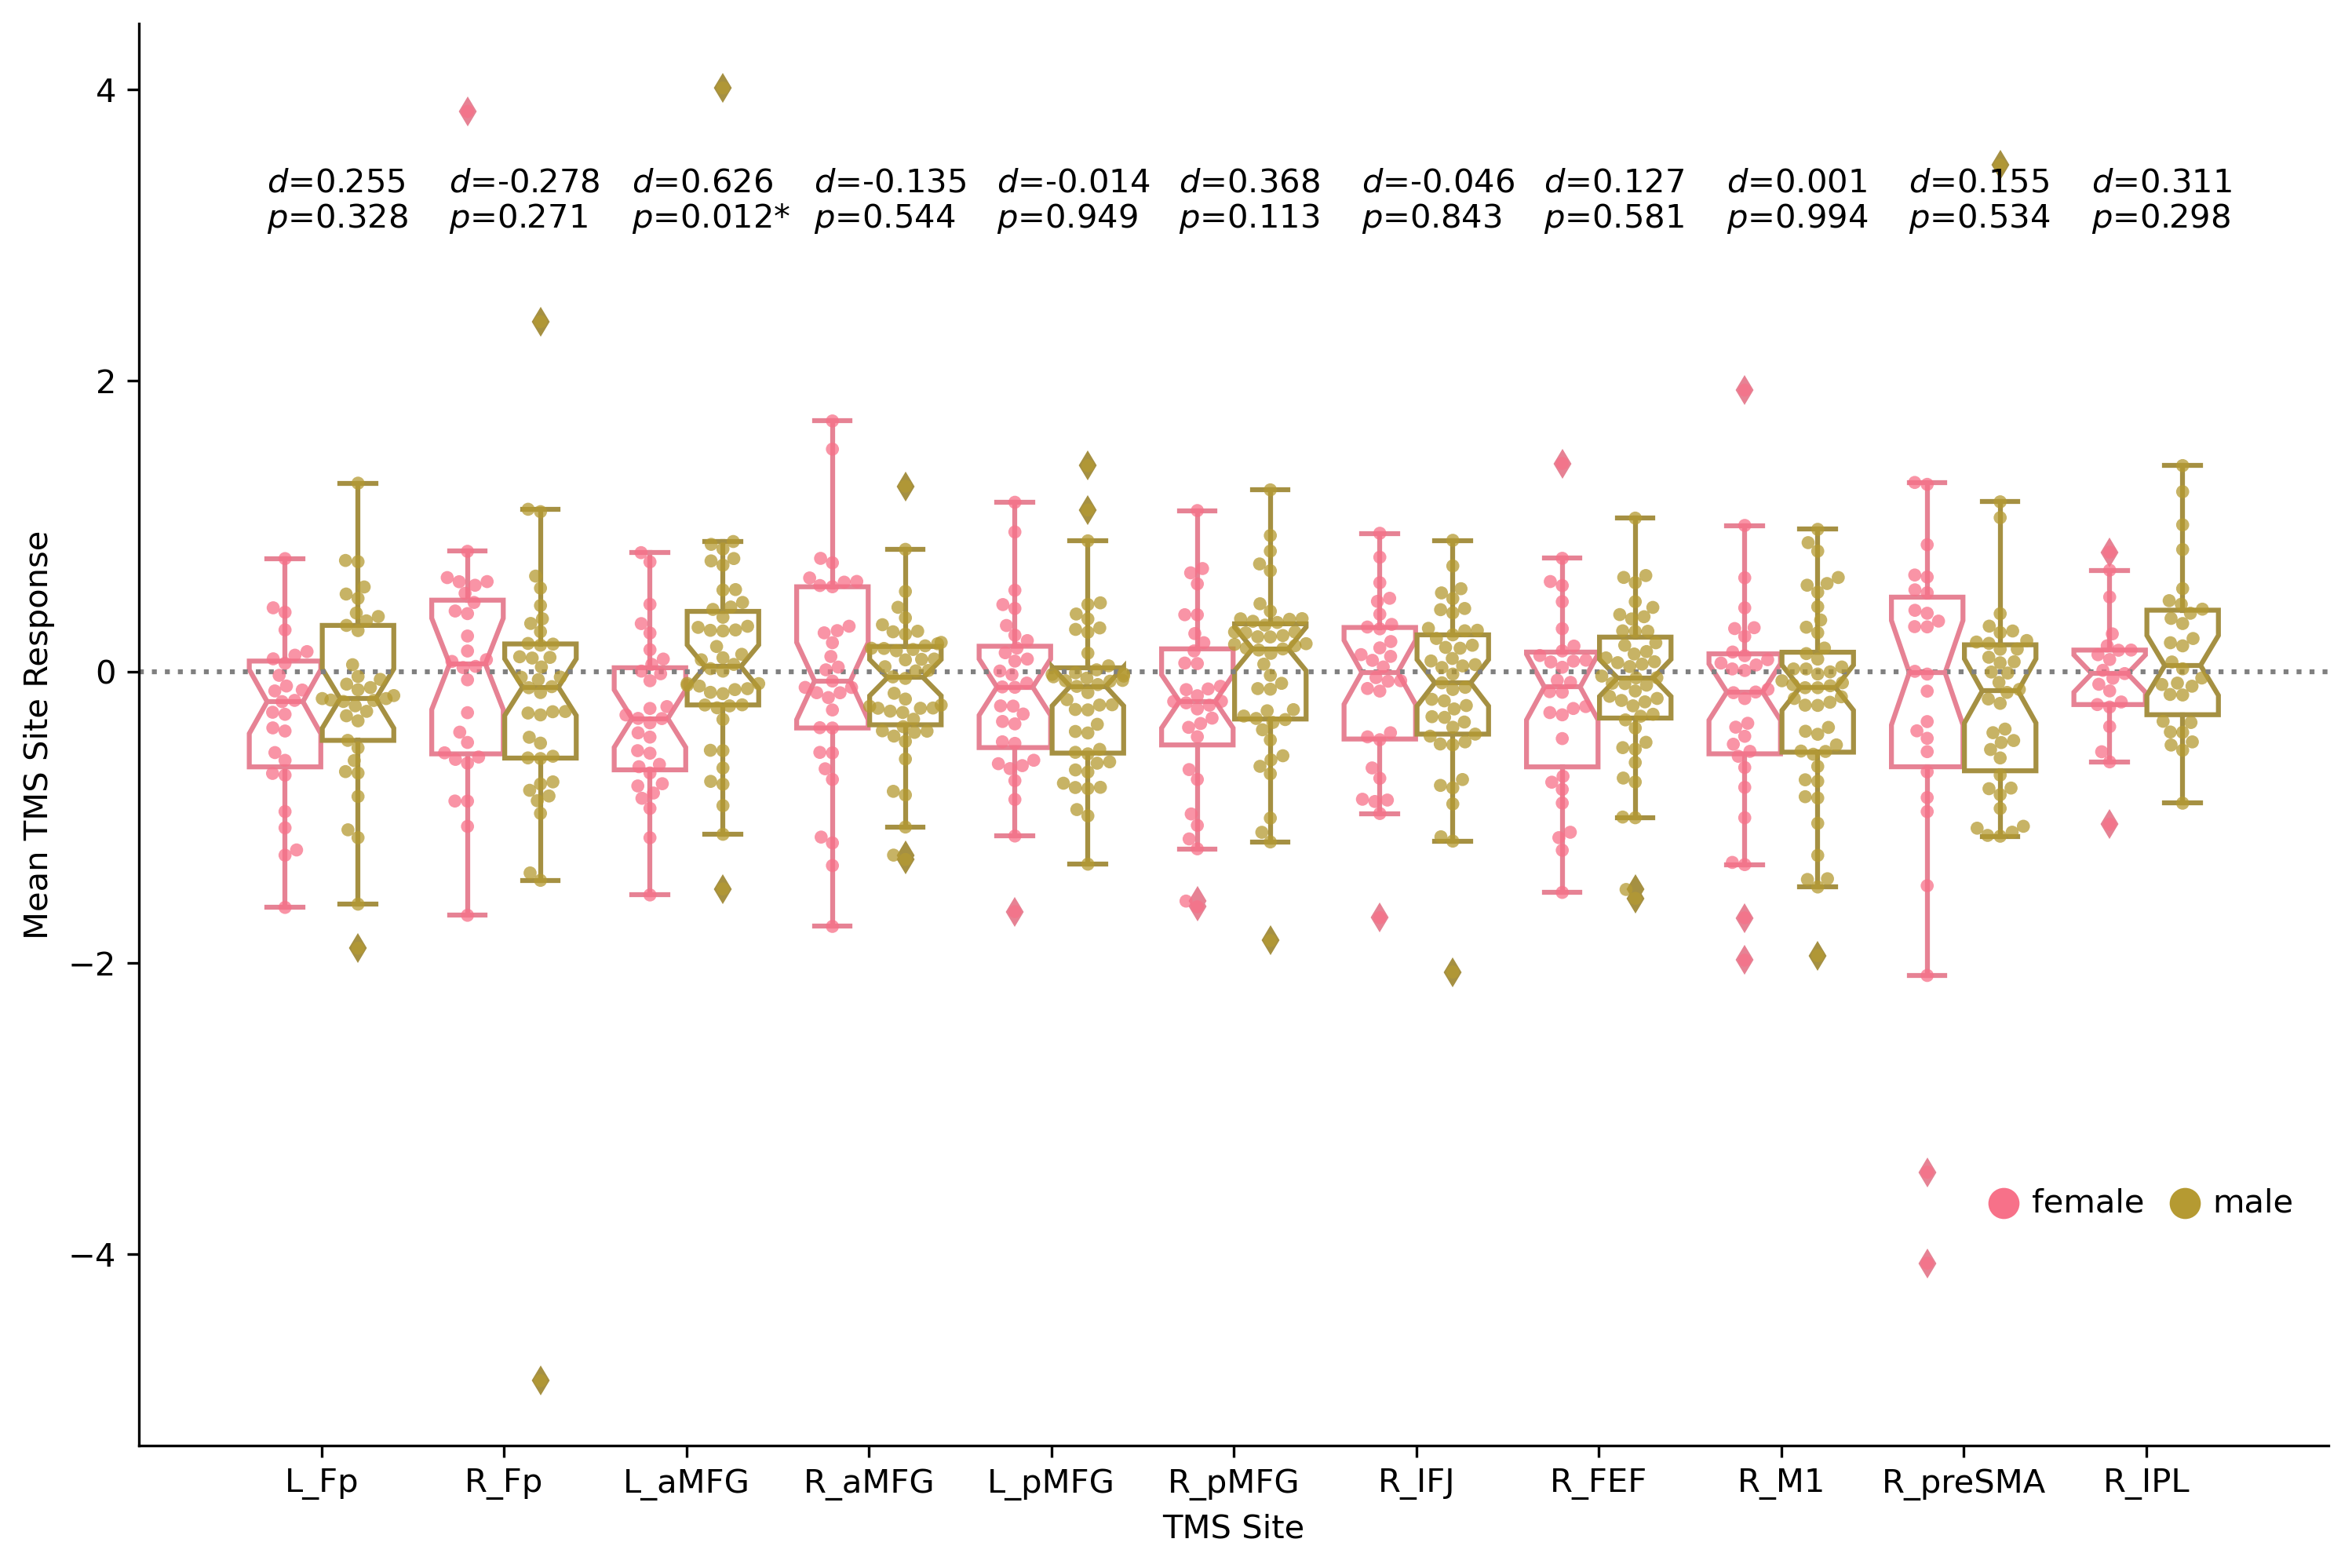

tms_site_response_individual_6mm


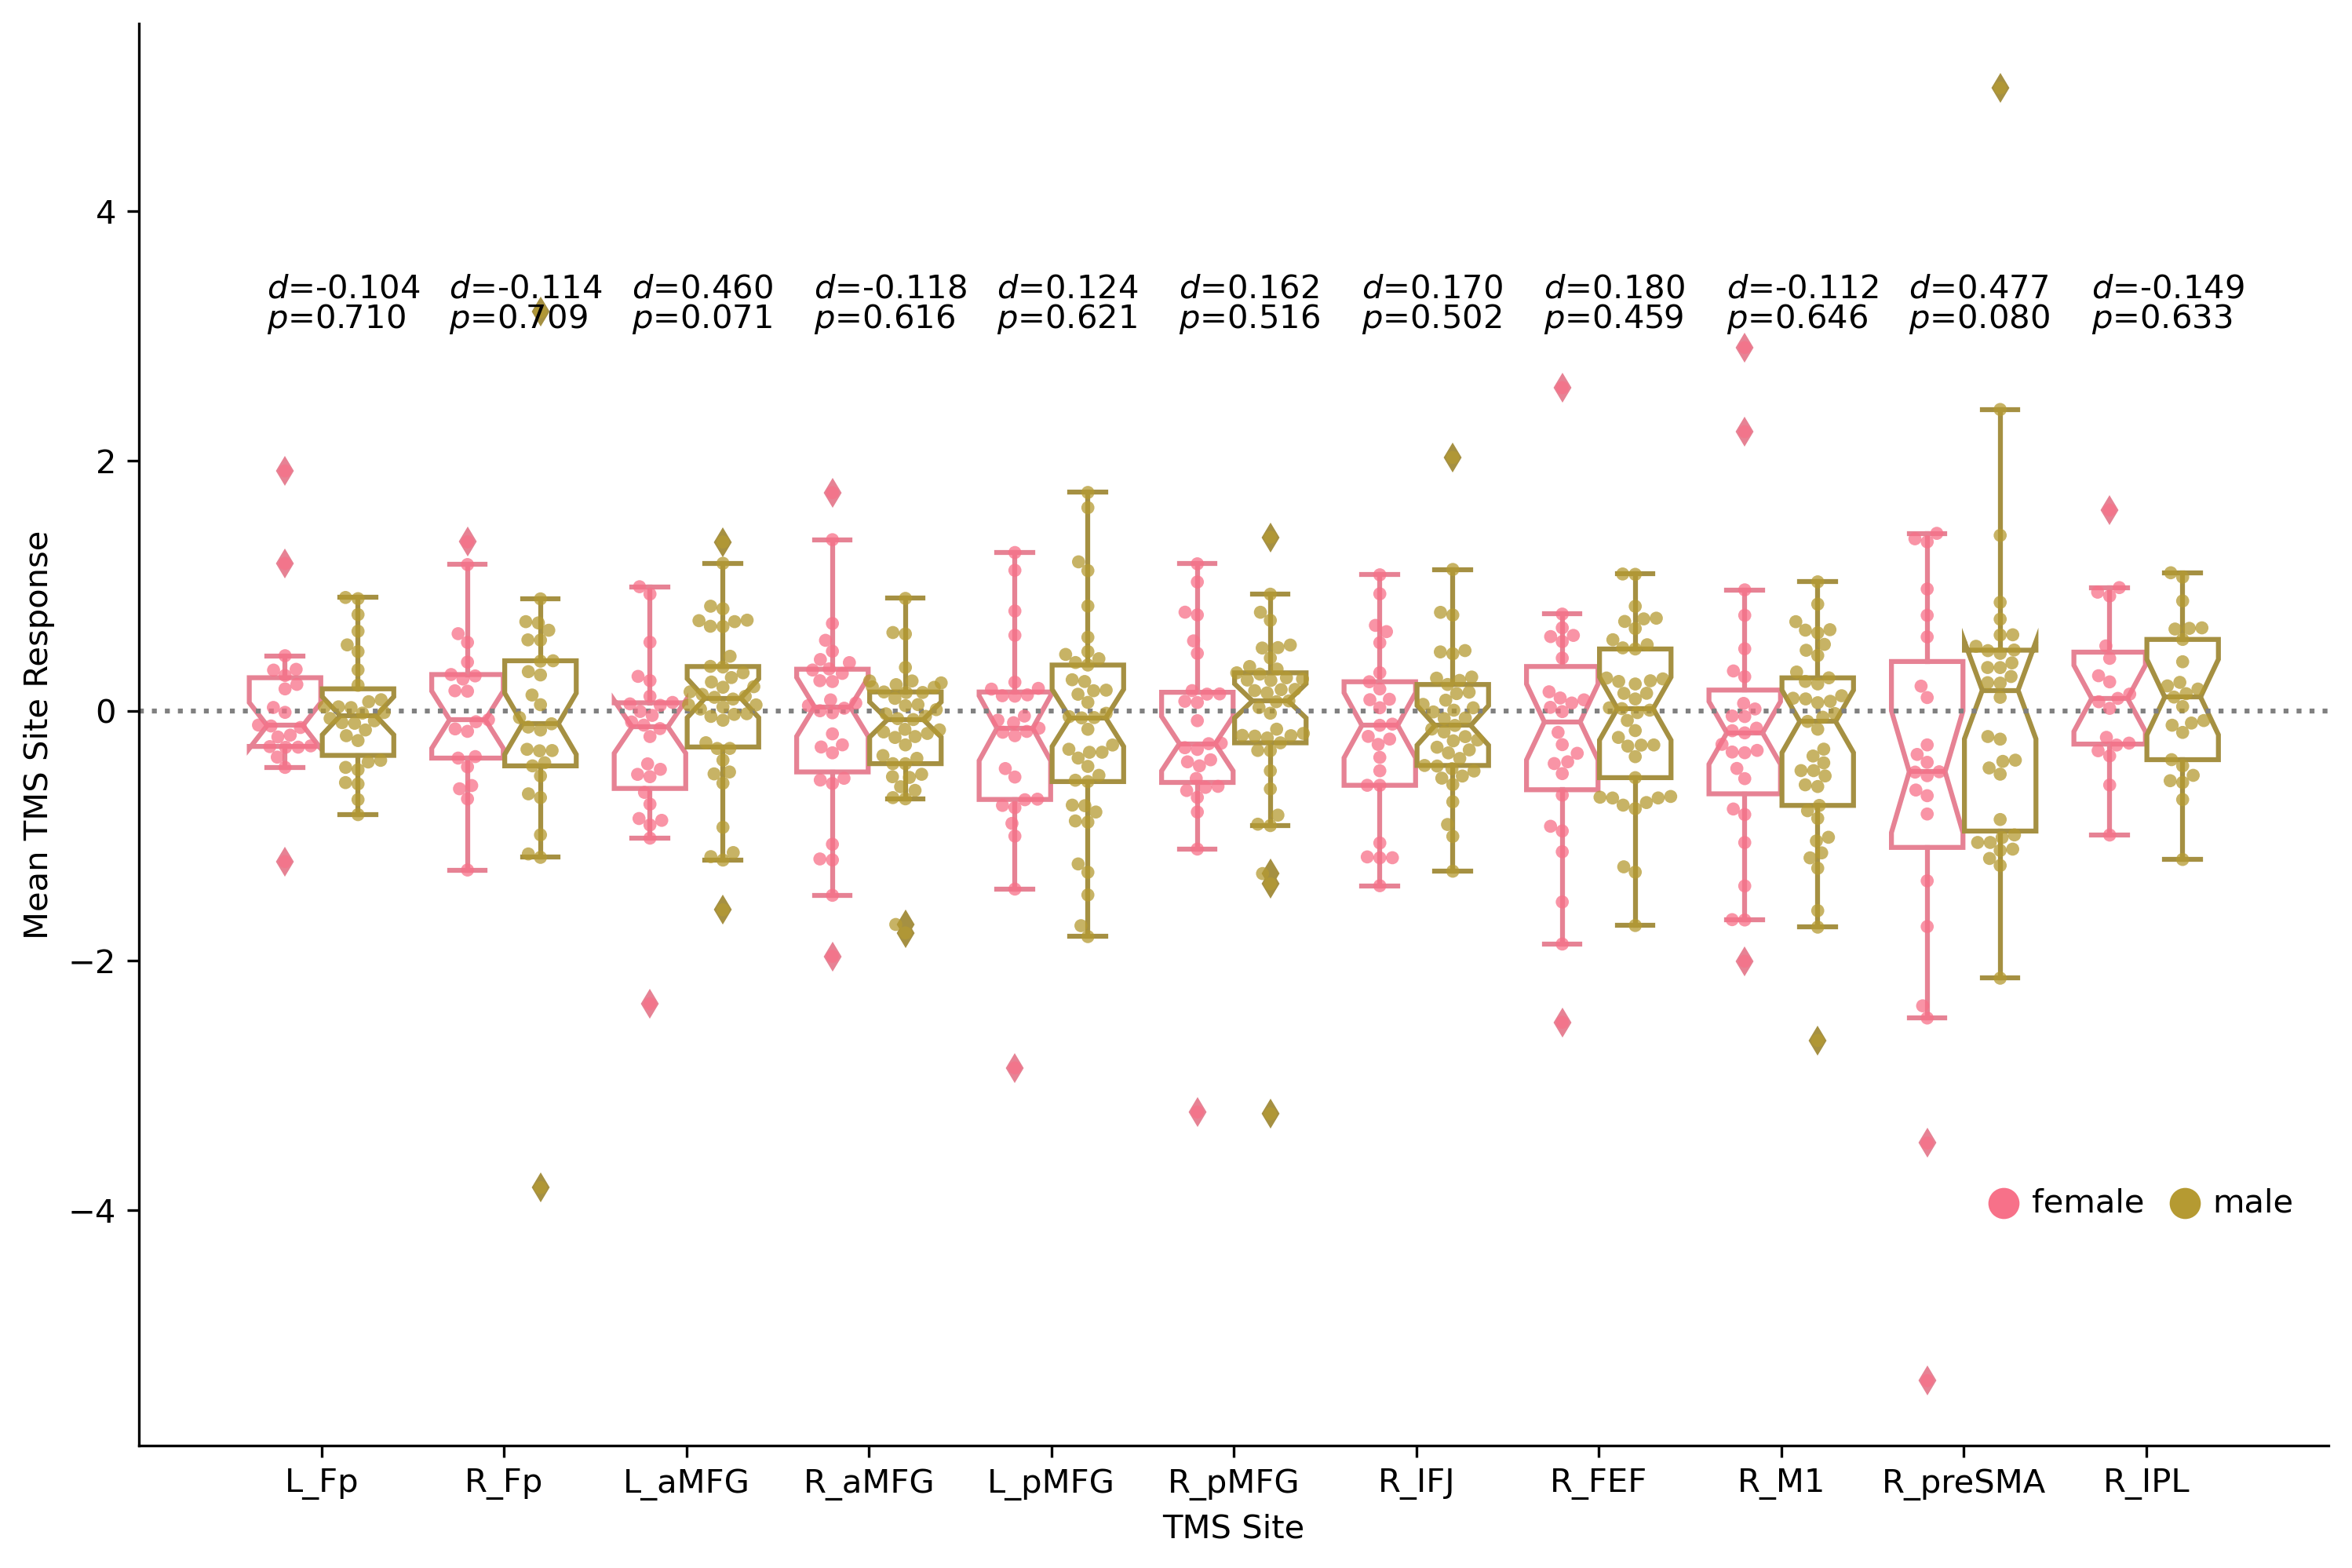

tms_site_response_individual_10mm


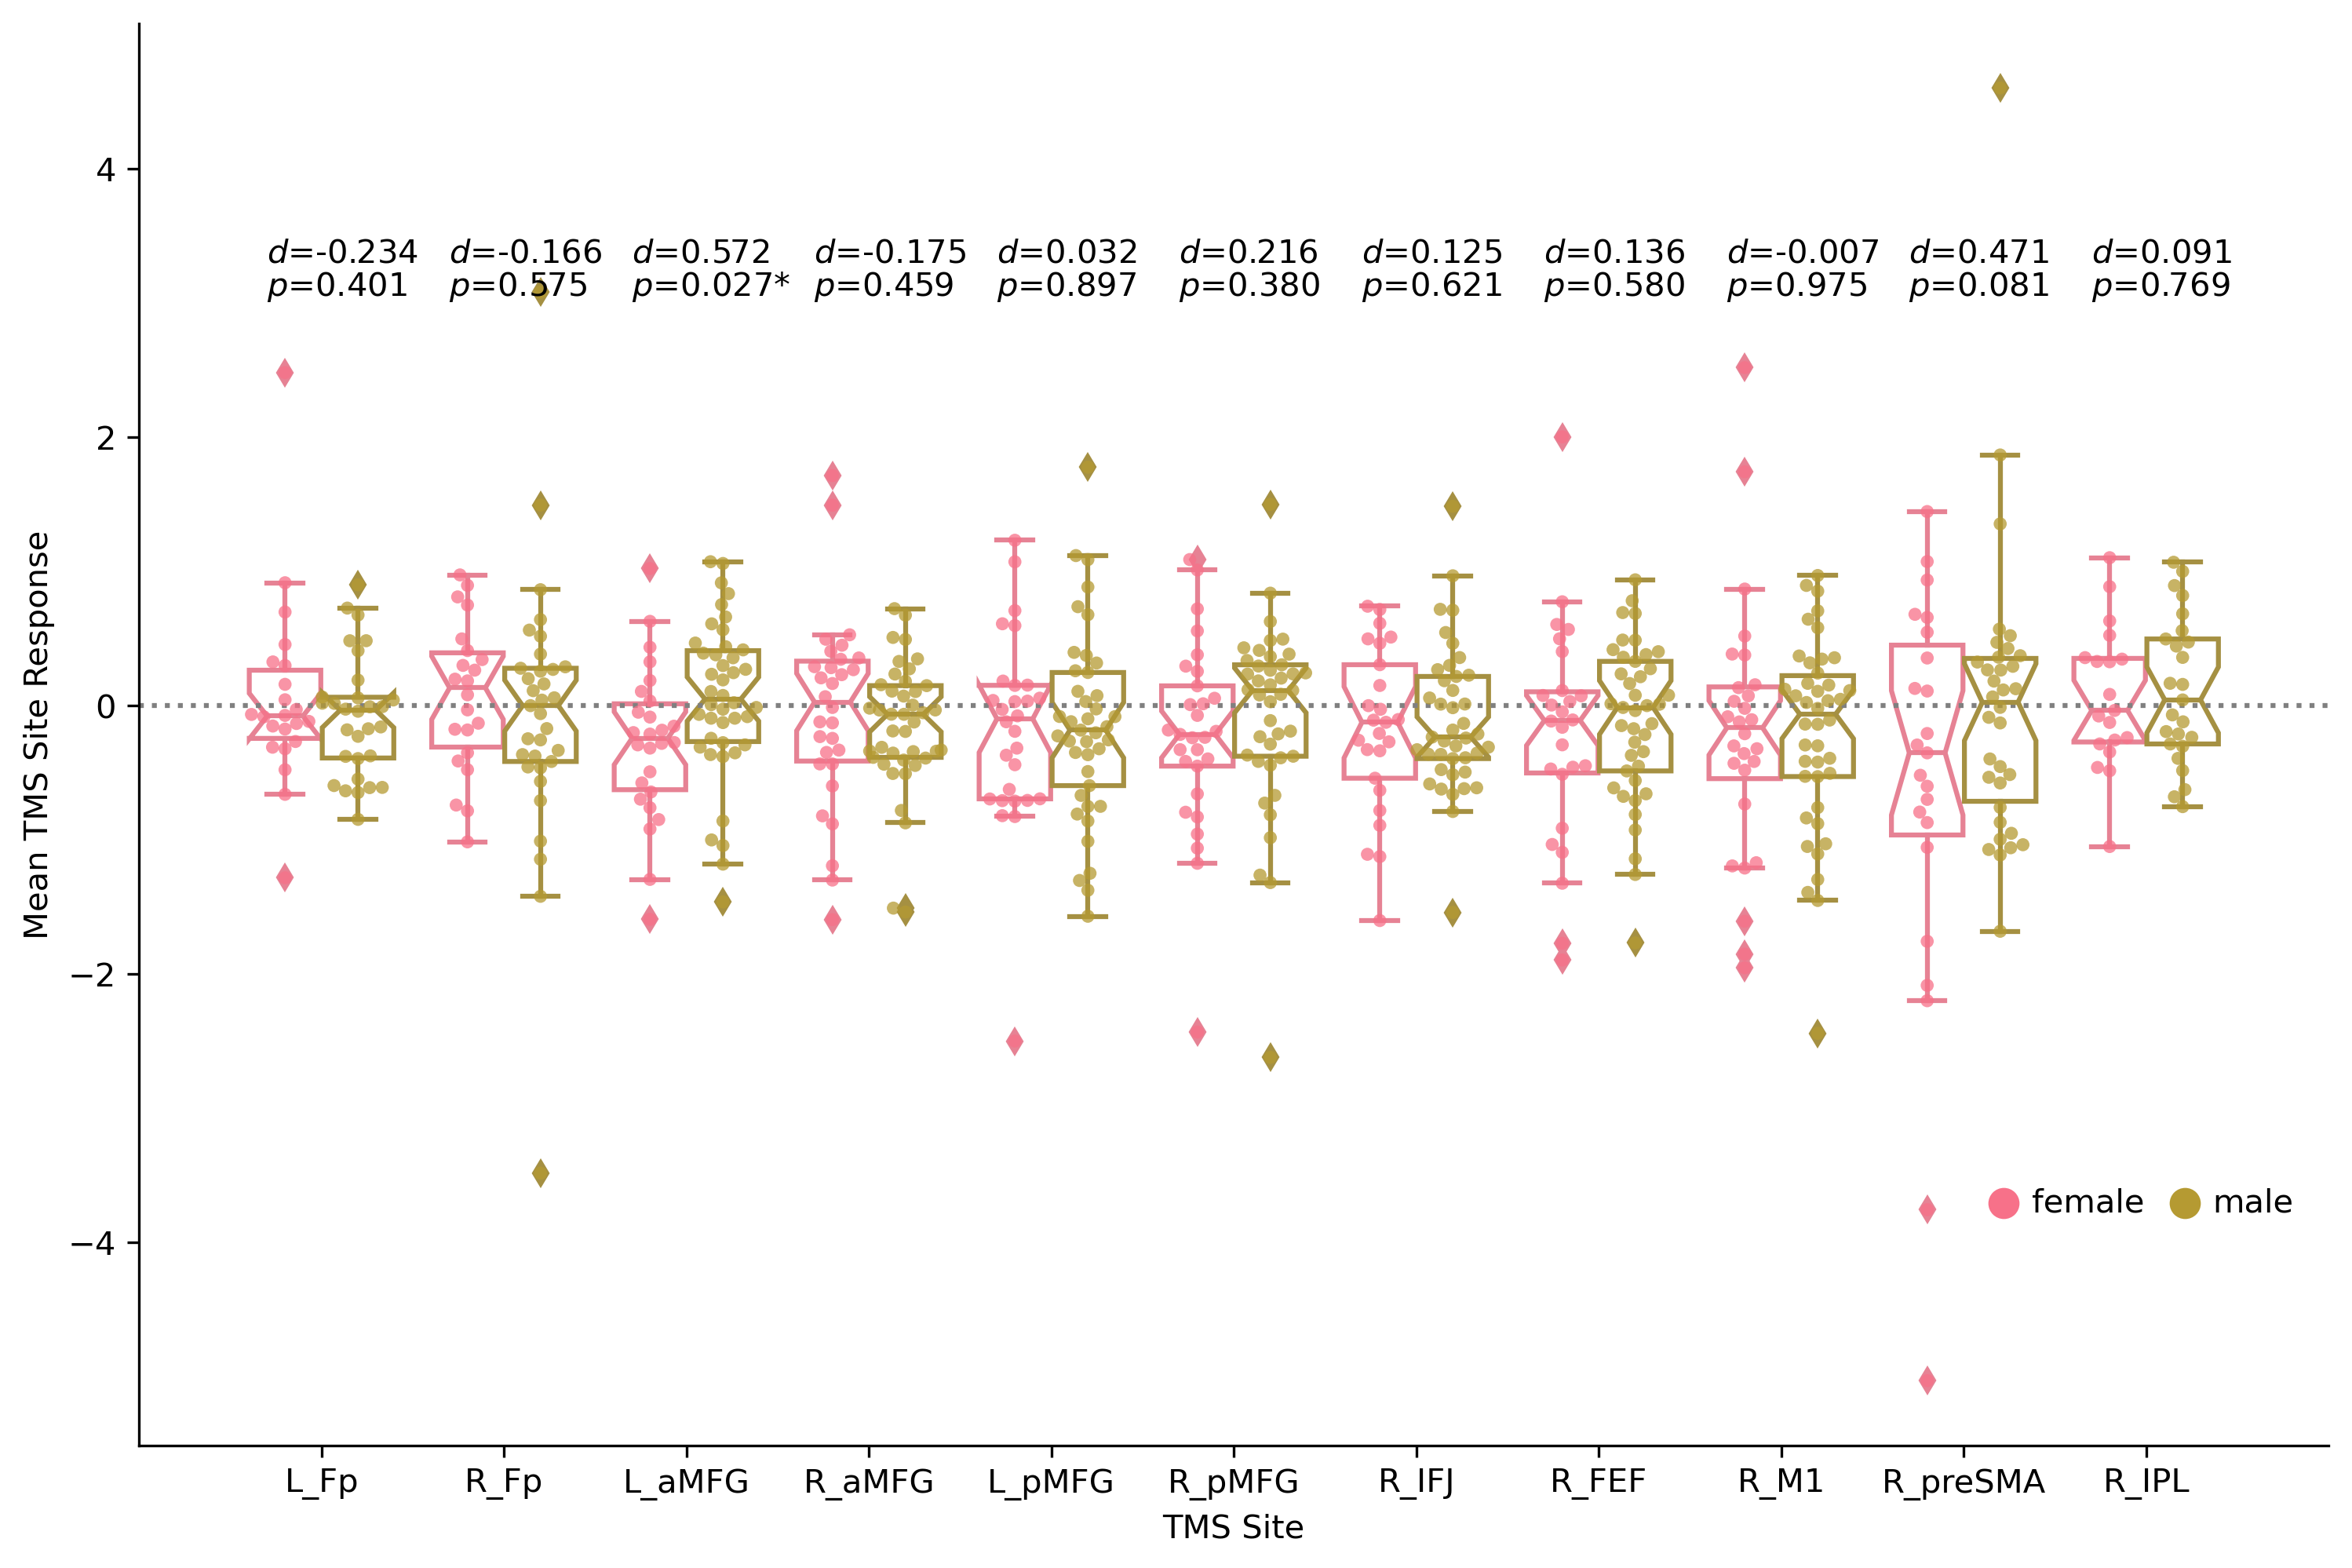

tms_site_response_individual_14mm


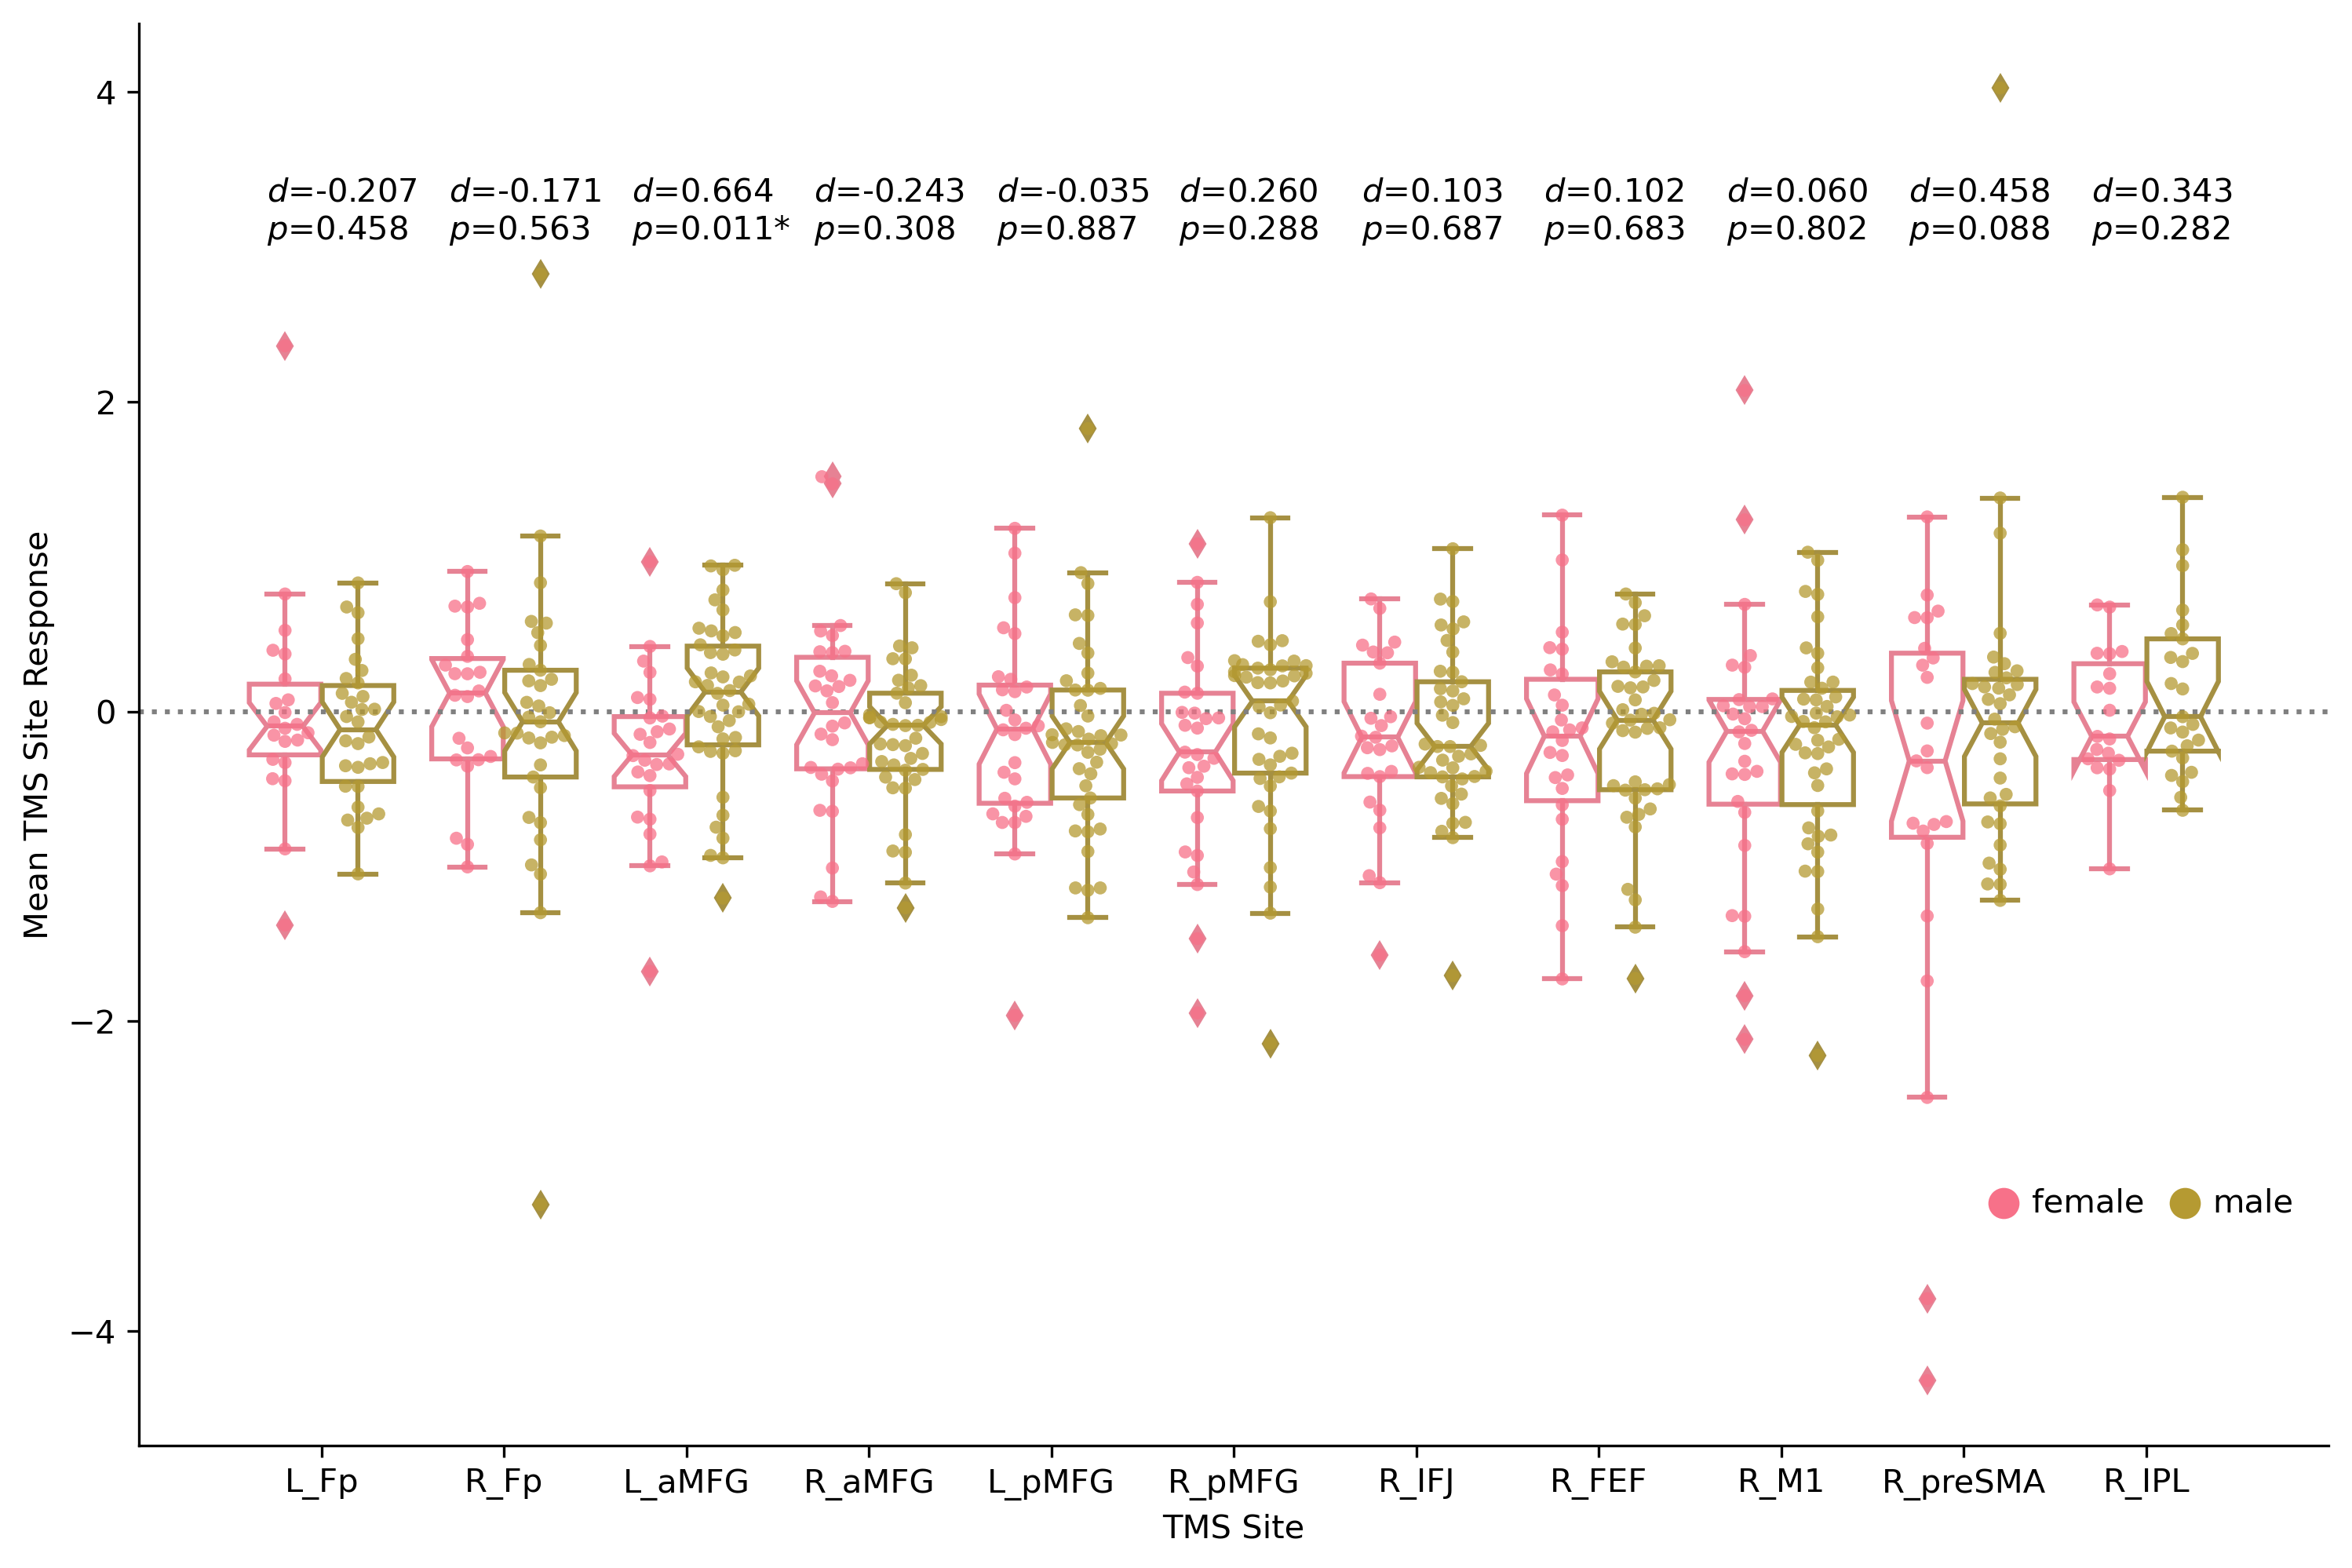

tms_site_response_individual_14-10mm


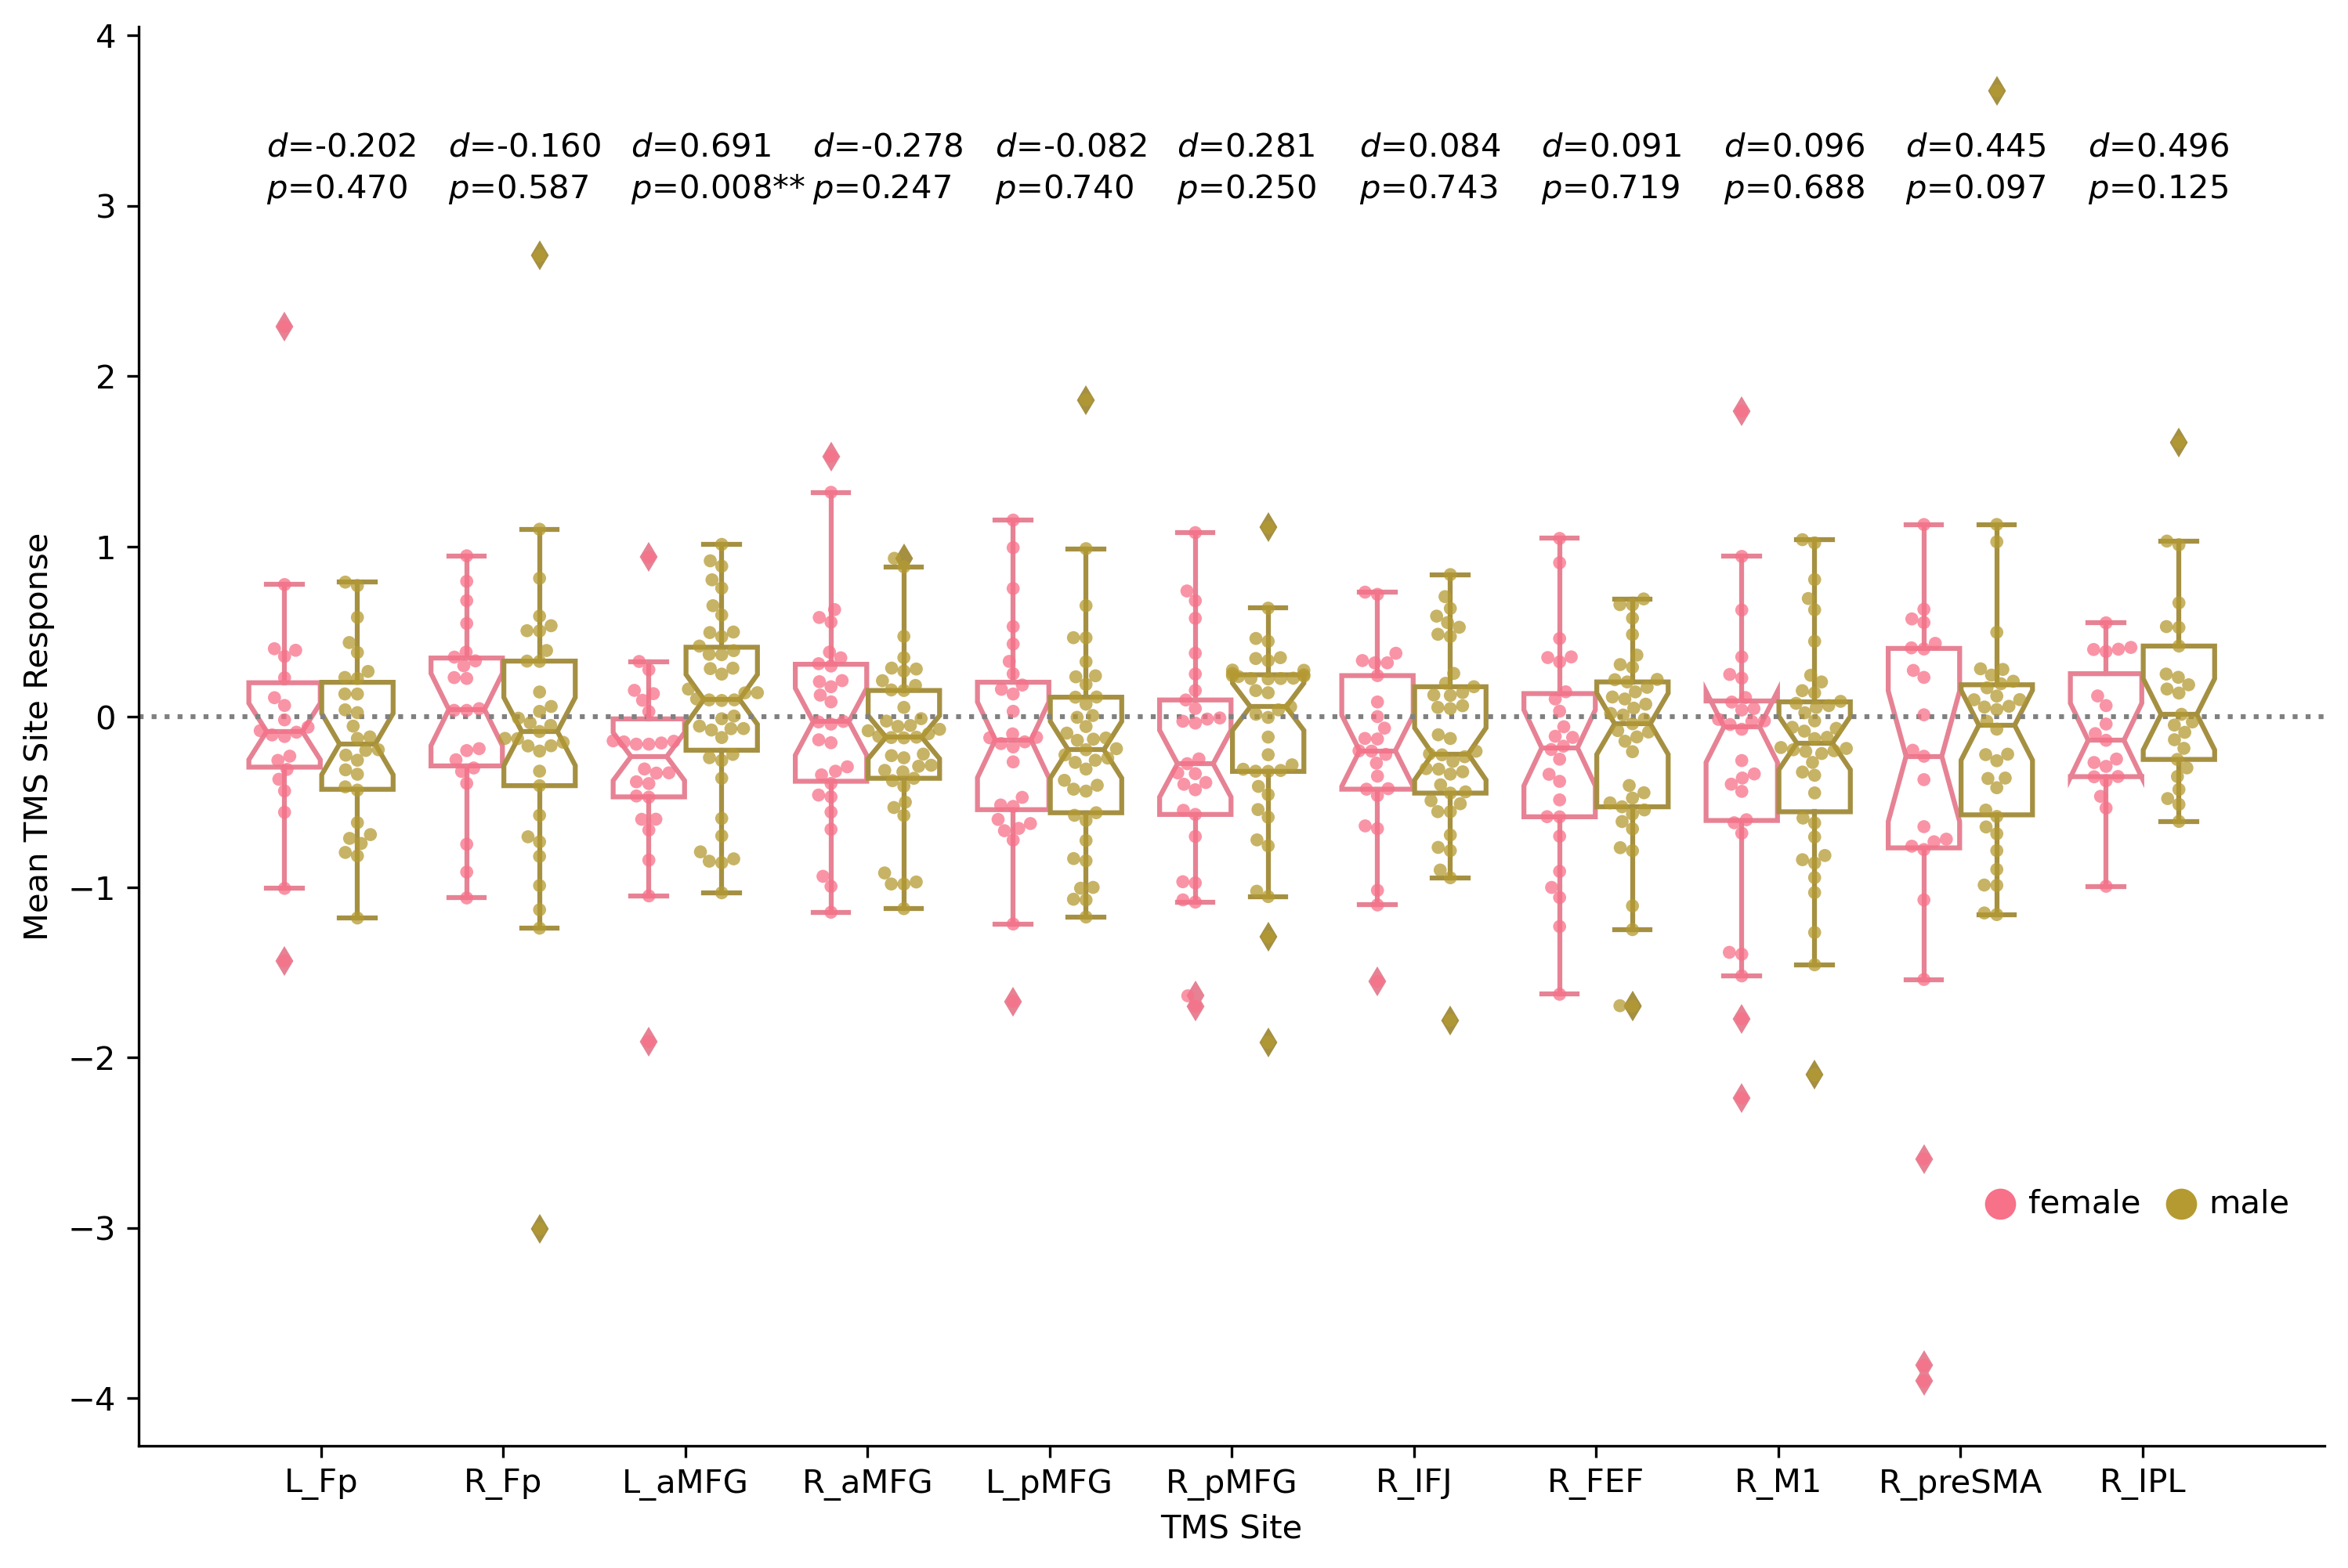

tms_site_response_individual_10-6mm


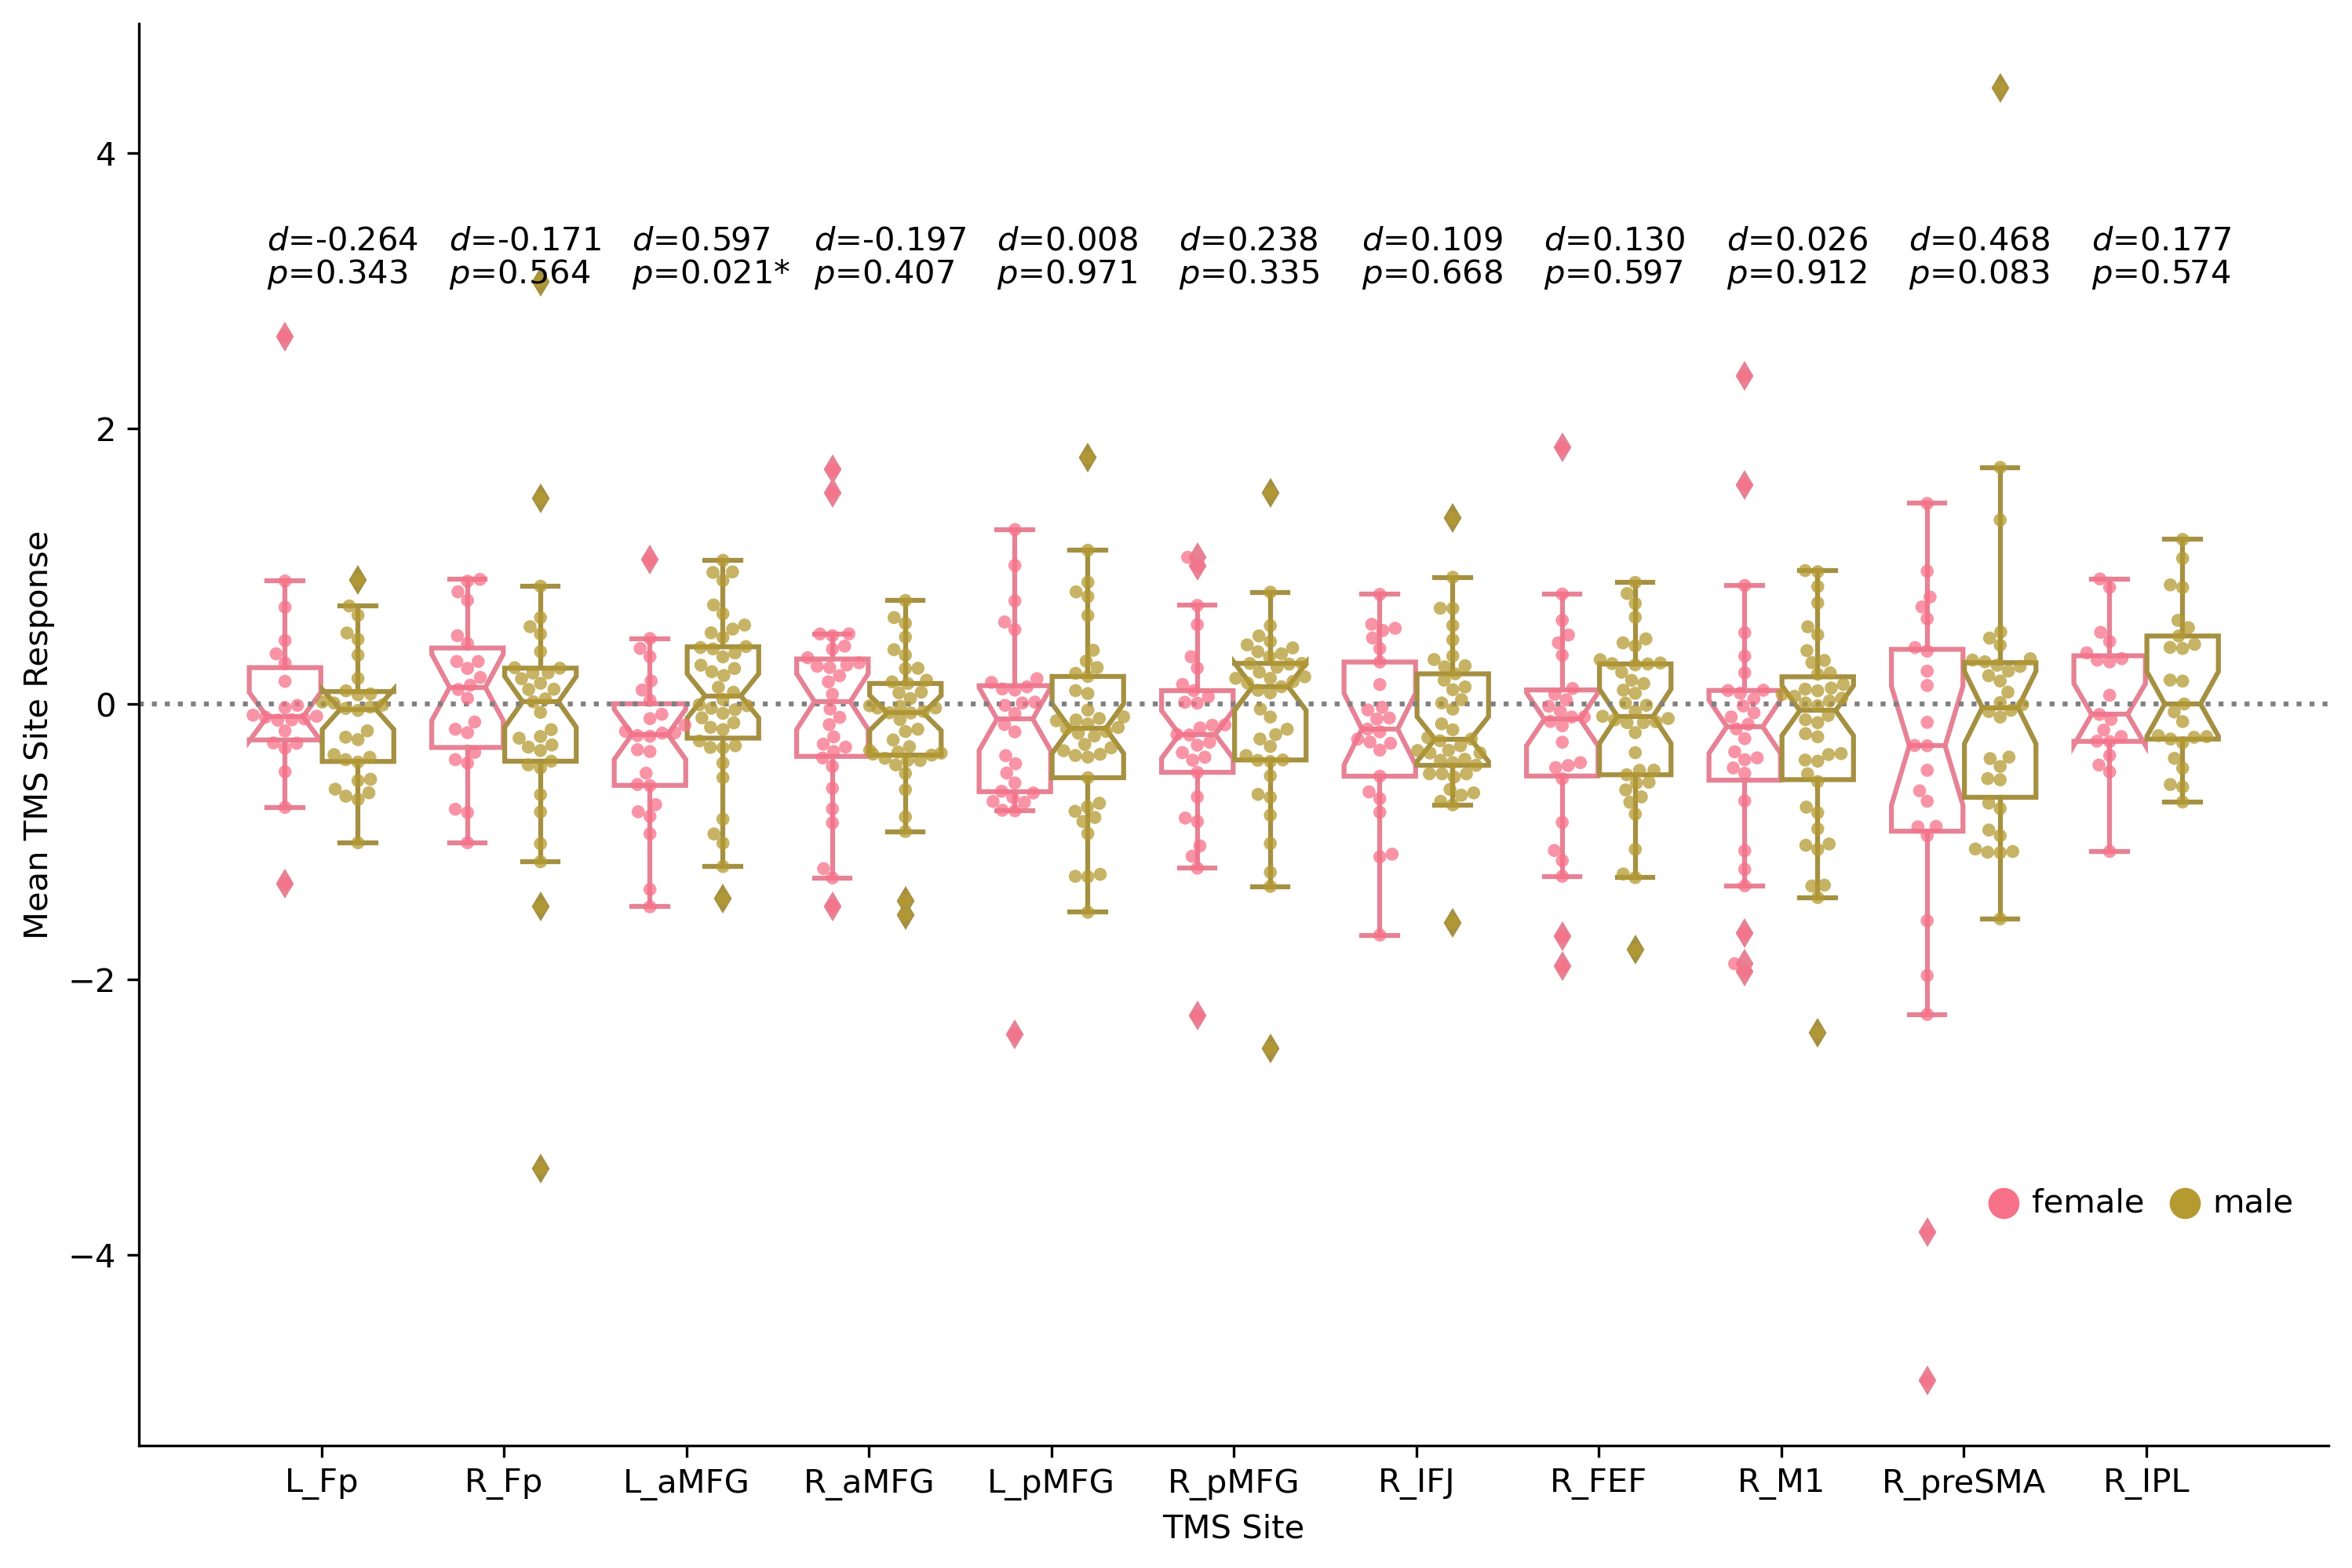

In [6]:

test_variables = ['tms_site_response_standard', 'tms_site_response_individual_6mm',
                  'tms_site_response_individual_10mm', 'tms_site_response_individual_14mm', 
                  'tms_site_response_individual_14-10mm', 'tms_site_response_individual_10-6mm']


for var in test_variables:
    print(var)
    fig = plot_response(var, result.loc[(var, 'p value'),:], result.loc[(var, "Cohen's d"),:])
    plt.show()
    fig.savefig(out_dir+'/figure1_box_plot_tms_response' + var + '.png', dpi=600, 
                bbox_inches = 'tight', pad_inches = 0.1)
    